In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time 
from numba import jit, njit, prange
from scipy.optimize import curve_fit
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numba.typed import List
import pickle
#from SimUtils import *

In [2]:
xlen = 2 #mm this is actually the trap z axis
ylen = 0.75 #mm
step = 5*10**(-3)
needle_spacing  = 2 # mm
Xaxis = np.arange(-xlen,xlen+step,step)
Yaxis = np.arange(-ylen,ylen+step,step)
X,Y = np.meshgrid(Xaxis,Yaxis)
diameter = 0.5 #mm

In [3]:
def R_cones(z,needle_spacing,diameter):
    '''
    params:
    z: coordinate z of the point of interest ( along trap z axis)
    needle_spacing: needle tip to tip distance
    diameter: diameter of the needle at the end of the z_value i.e rod end diameter
    
    returns:
    R: the radius of the cone for given z value
    '''
    z_0 = needle_spacing * 0.5
    if np.abs(z) < z_0 :
        return 0
    if np.abs(z) >= z_0 : 
        return 0.5 * diameter/(xlen - z_0) * (np.abs(z) - z_0)

def R_parabolic(z,needle_spacing,diameter):
    '''
    diameter: the diameter of the needle at the end of the z_value'''
    z_0 = needle_spacing * 0.5
    if np.abs(z) < z_0 :
        return 0
    if np.abs(z) >= z_0 :
        return 0.5 * diameter/((xlen - z_0)**0.5) * (np.abs(z)-z_0)**0.5 
    
def Tip_rad_cur(needle_spacing,diameter):
    '''
    Returns:
    R: radius of curvature for a parabolic tip defined as per R_parabolic
    see https://en.wikipedia.org/wiki/Radius_of_curvature for reference (2D formula)
    for a function y = a * x**(1/2), R = a**2 / 2 at tip i.e at x = 0
    '''
    z_0 = needle_spacing * 0.5
    return (0.5 * diameter/((xlen - z_0)**0.5))**2 / 2

def Dia_giv_rad_cur(needle_spacing,rad_cur):
    z_0 = needle_spacing * 0.5
    return ( 8 * rad_cur * (xlen - z_0 ) )**0.5


def draw_cones(X,Y,needle_spacing,diameter):
    '''
    writes 1 to the points where conical needles are located
    '''
    cones = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if (np.abs(X[i,j]) > (needle_spacing*0.5)) & (np.abs(Y[i,j]) <= np.abs(R_cones(X[i,j],needle_spacing,diameter))) :
                cones[i,j] = 1
    return cones      


def draw_parabolic(X,Y,needle_spacing,diameter):
    '''
    writes 1 to the points where parabolic needles are located

    '''
    cones = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if (np.abs(X[i,j]) > (needle_spacing*0.5)) & (np.abs(Y[i,j]) <= np.abs(R_parabolic(X[i,j],needle_spacing,diameter))) :
                cones[i,j] = 1
    return cones

def draw_parabolic_single(X,Y,needle_spacing,diameter):
    
    cones = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if (X[i,j] > (needle_spacing*0.5)) & (np.abs(Y[i,j]) <= np.abs(R_parabolic(X[i,j],needle_spacing,diameter))) :
                cones[i,j] = 1
    return cones

def draw_parabolic_asym(X,Y,needle_spacing,diameter,asym_factor):
    '''
    asym_factor: difference between the diameter of the two needles at the rod end
    '''
    cones = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if X[i,j] > 0:
                if (np.abs(X[i,j]) > (needle_spacing*0.5)) & (np.abs(Y[i,j]) <= np.abs(R_parabolic(X[i,j],needle_spacing,diameter))) :
                    cones[i,j] = 1
            if X[i,j] < 0:
                if (np.abs(X[i,j]) > (needle_spacing*0.5)) & (np.abs(Y[i,j]) <= np.abs(R_parabolic(X[i,j],needle_spacing,diameter+asym_factor))) :
                    cones[i,j] = 1
    return cones

def set_grid_points(blades):
    grid_points = List()
    for i in range(0,blades.shape[0]-1):
        for j in range(0,blades.shape[1]-1):
            if blades[i,j] == 0 :            
                grid_points.append((i,j))
    return grid_points


@jit(nopython=True)
def fast_numb_solve_test(blades,gp,iterations,tol):
    #largest_update = 0
    for iteration in range(0,iterations):
        largest_update = 0
        for grid_point in gp:
            i = grid_point[0]
            j = grid_point[1]
            value = 0.25 * (blades[i+1,j] + blades[i-1,j] + blades[i,j+1] + blades[i,j-1])
            update = np.abs(value - blades[i,j])
            blades[i,j] = value 
            if update > largest_update : 
                largest_update = update
        if largest_update < tol:
            break
#     print(iteration)
#     print(largest_update)
    return blades



q = 1.60217662*(10**(-19))
m = 2.8395214559472*10**(-25)



def fit_quadratic(z,V_0,K):
    return V_0 + 0.5 * K * z**2

def trapfreq(k):
    return np.sqrt(np.abs(k)/m)/(2*np.pi)



def solve_parabolic(X,Y,needle_spacing,diameter):
    needle_parabolic = draw_parabolic(X,Y,needle_spacing,diameter)
    grid_points_parabolic = set_grid_points(needle_parabolic)
    parabolic_solved = fast_numb_solve_test(needle_parabolic,grid_points_parabolic,100000,1e-6)
    roi = 15
    z_center = (X.shape[1]-1)//2
    z_data = X[150,z_center-roi:z_center+roi+1] * 1e-3
    v_data = parabolic_solved[150,z_center-roi:z_center+roi+1] * q
    popt, pconv = curve_fit(fit_quadratic,z_data,v_data)
    
    return trapfreq(popt[1])


def solve_cone(X,Y,needle_spacing,diameter):
    needle_cone = draw_cones(X,Y,needle_spacing,diameter)
    grid_points_cones = set_grid_points(needle_cone)
    cone_solved = fast_numb_solve_test(needle_cone,grid_points_cones,100000,1e-6)
    roi = 15
    z_center = (X.shape[1]-1)//2
    z_data = X[150,z_center-roi:z_center+roi+1] * 1e-3
    v_data = cone_solved[150,z_center-roi:z_center+roi+1] * q
    popt, pconv = curve_fit(fit_quadratic,z_data,v_data)
    return trapfreq(popt[1])

# Testing

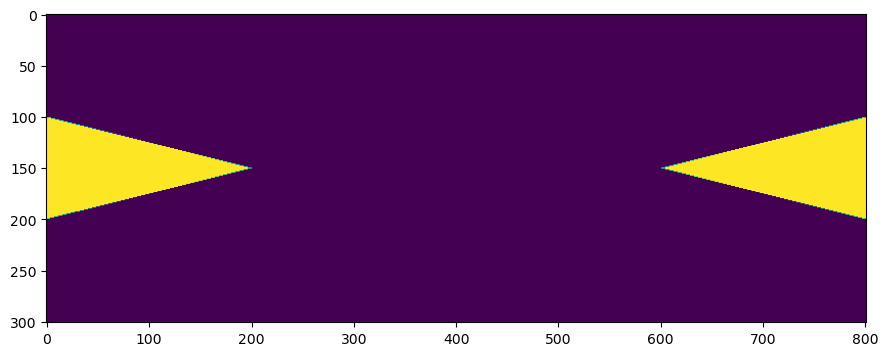

Wall time: 1.65 s


In [4]:
%%time
conical_pair = draw_cones(X,Y,needle_spacing,diameter)
fig = plt.figure(figsize = (16,4))
ax1 = fig.add_subplot(111)
ax1.imshow(conical_pair)
plt.show()

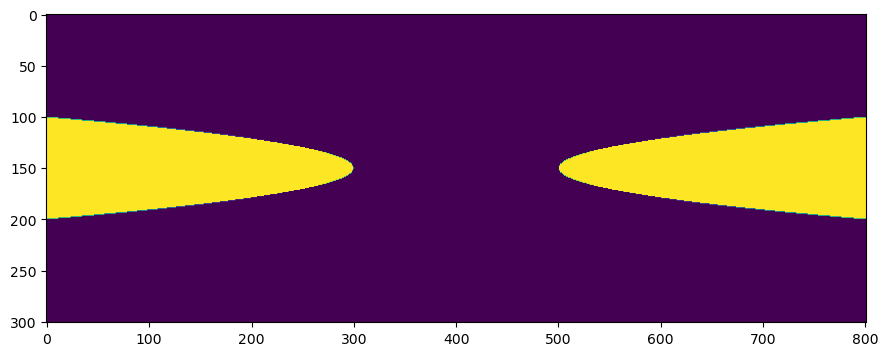

Wall time: 2.02 s


In [5]:
%%time
needle_spacing = 1
parabolic_pair = draw_parabolic(X,Y,needle_spacing,diameter)
fig = plt.figure(figsize = (16,4))
ax1 = fig.add_subplot(111)
ax1.imshow(parabolic_pair)
plt.show()

In [6]:
%%time
parabolic_pair_grid_points = np.array(set_grid_points(parabolic_pair))

Wall time: 1.9 s


In [7]:
%%time
parabolic_pair_solved = fast_numb_solve_test(parabolic_pair,parabolic_pair_grid_points,100000,1e-6)

Wall time: 54.1 s


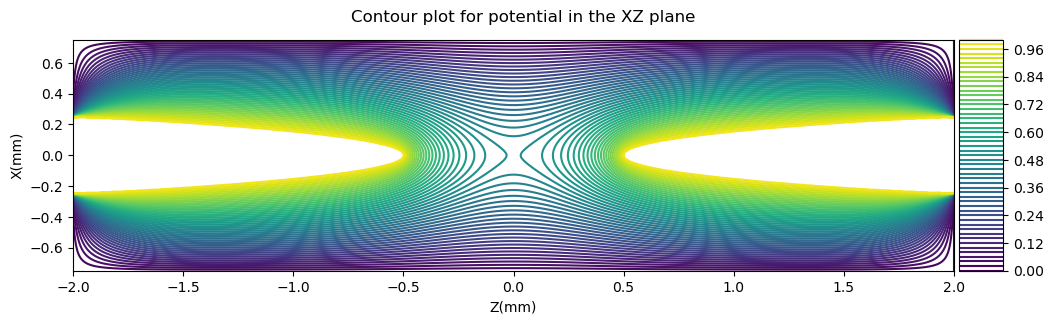

In [8]:
fig = plt.figure(figsize = (12,3))
fig.suptitle('Contour plot for potential in the XZ plane')
ax1 = fig.add_subplot(111)
im = ax1.contour(X,Y,parabolic_pair_solved,50)
ax1.set_xlabel('Z(mm)')
ax1.set_ylabel('X(mm)')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

In [9]:
parabolic_pair_solved.shape

(301, 801)

190156.50686265583


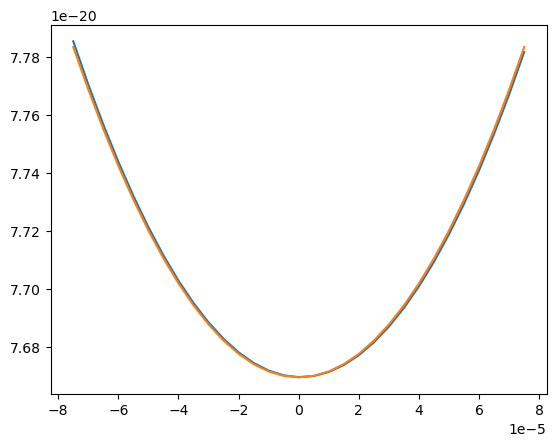

In [10]:
roi = 15
z_center = (X.shape[1]-1)//2
z_data = X[150,z_center-roi:z_center+roi+1] * 1e-3
v_data = parabolic_pair_solved[150,z_center-roi:z_center+roi+1] * q
popt, pconv = curve_fit(fit_quadratic,z_data,1*v_data)
print( trapfreq(popt[1]) )
plt.plot(z_data,1*v_data)
plt.plot(z_data,fit_quadratic(z_data,*popt))

In [11]:
parabolic_pair_result = {'parabolic_pair_solved':parabolic_pair_solved, 'z_data':z_data,\
                        'v_data':v_data/q}

In [12]:
with open('parabolic_pair_result.pickle','wb') as f:
    pickle.dump(parabolic_pair_result,f,pickle.HIGHEST_PROTOCOL)

In [13]:
%%time
solve_parabolic(X,Y,needle_spacing,diameter)

Wall time: 59.1 s


190156.50686265583

# trap freq vs needle spacing for different radii of curvature
For legacy reasons the solver and accepts the needle diameter (rod end) as an input and not radius of curvature of the tip. The idea here is to have the diameters

In [14]:
Tip_rad_cur(needle_spacing,diameter)

0.02083333333333334

In [15]:
diameter == Dia_giv_rad_cur(needle_spacing, Tip_rad_cur(needle_spacing,diameter))

True

In [16]:
spacings = np.linspace(0.25,2,10)
dias_rad_20 = Dia_giv_rad_cur(spacings,20 * 1e-3)
dias_rad_40 = Dia_giv_rad_cur(spacings,40 * 1e-3)
dias_rad_60 = Dia_giv_rad_cur(spacings,60 * 1e-3)

In [17]:
dias_rad_60

array([0.9486833 , 0.92376043, 0.89814624, 0.87177979, 0.84459063,
       0.81649658, 0.78740079, 0.75718778, 0.72571804, 0.69282032])

In [18]:
%%time
trap_freq_20 = []
trap_freq_40 = []
trap_freq_60 = []


for needle_spacing,diameter in zip(spacings,dias_rad_20):
    trap_freq_20.append( solve_parabolic(X,Y,needle_spacing,diameter) )
    
for needle_spacing,diameter in zip(spacings,dias_rad_40):
    trap_freq_40.append( solve_parabolic(X,Y,needle_spacing,diameter) )
    
for needle_spacing,diameter in zip(spacings,dias_rad_60):
    trap_freq_60.append( solve_parabolic(X,Y,needle_spacing,diameter) )

Wall time: 23min 57s


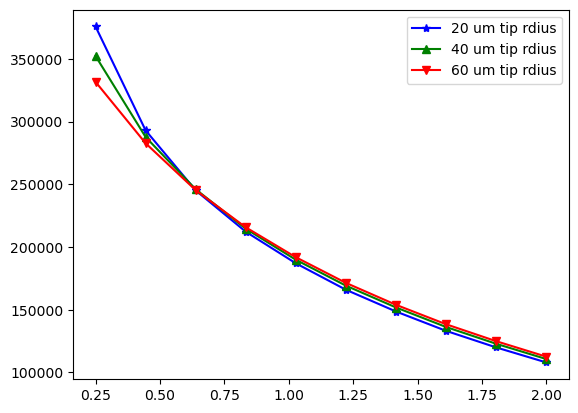

In [19]:
plt.plot(spacings,trap_freq_20,color='b',label='20 um tip rdius',marker='*')
plt.plot(spacings,trap_freq_40,color='g',label='40 um tip rdius',marker='^')
plt.plot(spacings,trap_freq_60,color='r',label='60 um tip rdius',marker='v')
plt.legend()

In [20]:
trap_freq_results = {'spacings':spacings, 'trap_freq_20':trap_freq_20, \
                     'trap_freq_40':trap_freq_40, 'trap_freq_60':trap_freq_60}
with open('trap_freq_results.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(trap_freq_results, f, pickle.HIGHEST_PROTOCOL)
    
# with open('trap_freq_results.pickle', 'rb') as f:
#     trap_freq_results = pickle.load(f)

# Asymmetric needles vs balanced

In [21]:
needle_spacing = 1.5
diameter = 0.25
needles_sym = draw_parabolic(X,Y,needle_spacing,diameter)
needles_asym = draw_parabolic_asym(X,Y,needle_spacing,diameter,0.5)

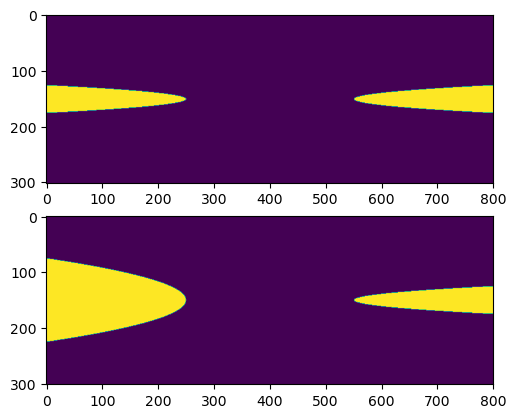

In [22]:
fig,ax = plt.subplots(2,1)
ax[0].imshow(needles_sym)
ax[1].imshow(needles_asym)
plt.show()

In [23]:
gp_sym = set_grid_points(needles_sym)
gp_asym = set_grid_points(needles_asym)
needles_sym_solved = fast_numb_solve_test(needles_sym,gp_sym,1e5,1e-6)
needles_asym_solved = fast_numb_solve_test(needles_asym,gp_asym,1e5,1e-6)

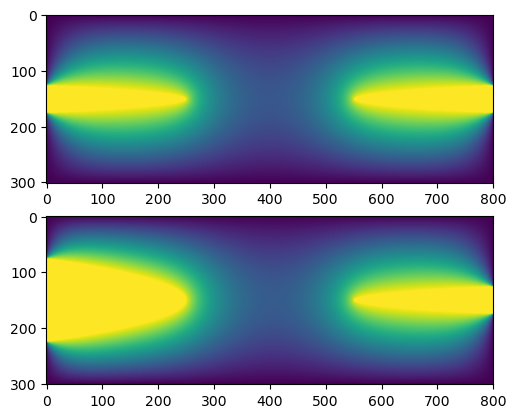

In [24]:
fig,ax = plt.subplots(2,1)
ax[0].imshow(needles_sym_solved)
ax[1].imshow(needles_asym_solved)
plt.show()

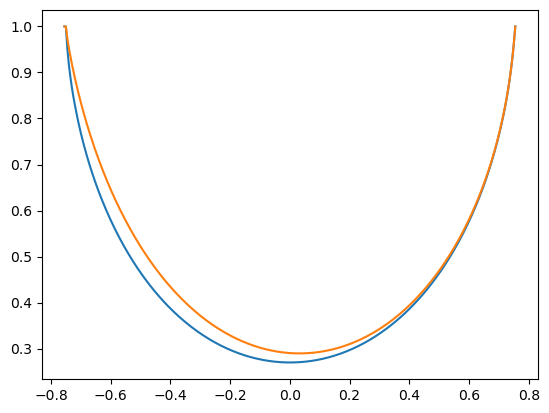

In [25]:
roi = 151
z_center = (X.shape[1]-1)//2
z_data = X[150,z_center-roi:z_center+roi+1]
v_data_sym = needles_sym[150,z_center-roi:z_center+roi+1]
v_data_asym = needles_asym[150,z_center-roi:z_center+roi+1]
plt.plot(z_data,v_data_sym)
plt.plot(z_data,v_data_asym)

In [26]:
asym_needles_results = {'needles_sym_solved': needles_sym_solved, 'needles_asym_solved': needles_asym_solved,\
                       'z_data':z_data,'v_data_sym':v_data_sym,'v_data_asym' : v_data_asym}

with open('asym_needles_results.pickle','wb') as f:
    pickle.dump(asym_needles_results,f, pickle.HIGHEST_PROTOCOL)
    


# Parabolic needles vs conical needles

In [27]:
spacings = np.linspace(0.25,2,10)
diameter = 0.5
trap_freqs_cones = []
for spacing,diameter in zip(spacings,dias_rad_20):
    trap_freqs_cones.append( solve_cone(X,Y,needle_spacing,diameter) )

In [28]:
%%time
spacings = np.linspace(0.25,2,10)
cone_frequencies = []
parabolic_frequencies = []
diameter = 0.5
for spacing in spacings:
    cone_freq = solve_cone(X,Y,spacing,diameter)
    para_freq = solve_parabolic(X,Y,spacing,diameter)
    cone_frequencies.append(cone_freq)
    parabolic_frequencies.append(para_freq)

Wall time: 17min 16s


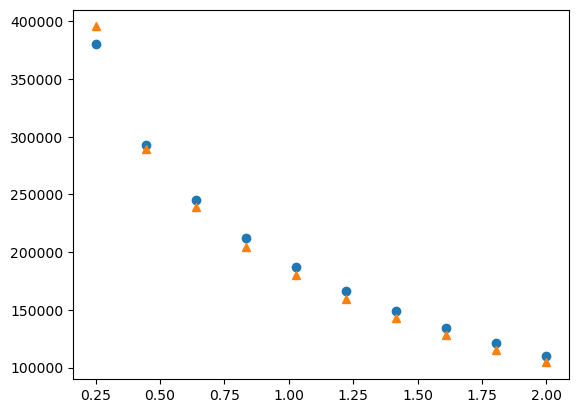

In [29]:
plt.plot(spacings,parabolic_frequencies,'o')
plt.plot(spacings,cone_frequencies,'^')

In [30]:
cone_vs_para_results = {'cone_frequencies':cone_frequencies, 'parabolic_frequencies':parabolic_frequencies,\
                       'diameter':diameter, 'spacings':spacings}

with open('cone_vs_para_results.pickle','wb') as f:
    pickle.dump(cone_vs_para_results,f,pickle.HIGHEST_PROTOCOL)



# Final Figure

In [31]:
with open('parabolic_pair_result.pickle','rb') as f:
    parabolic_pair_result = pickle.load(f)
    
with open('trap_freq_results.pickle', 'rb') as f:
    trap_freq_results = pickle.load(f)
    
with open('asym_needles_results.pickle', 'rb') as f:
    asym_needles_results = pickle.load(f)
    
with open('cone_vs_para_results.pickle','rb') as f:
    cone_vs_para_results = pickle.load(f)

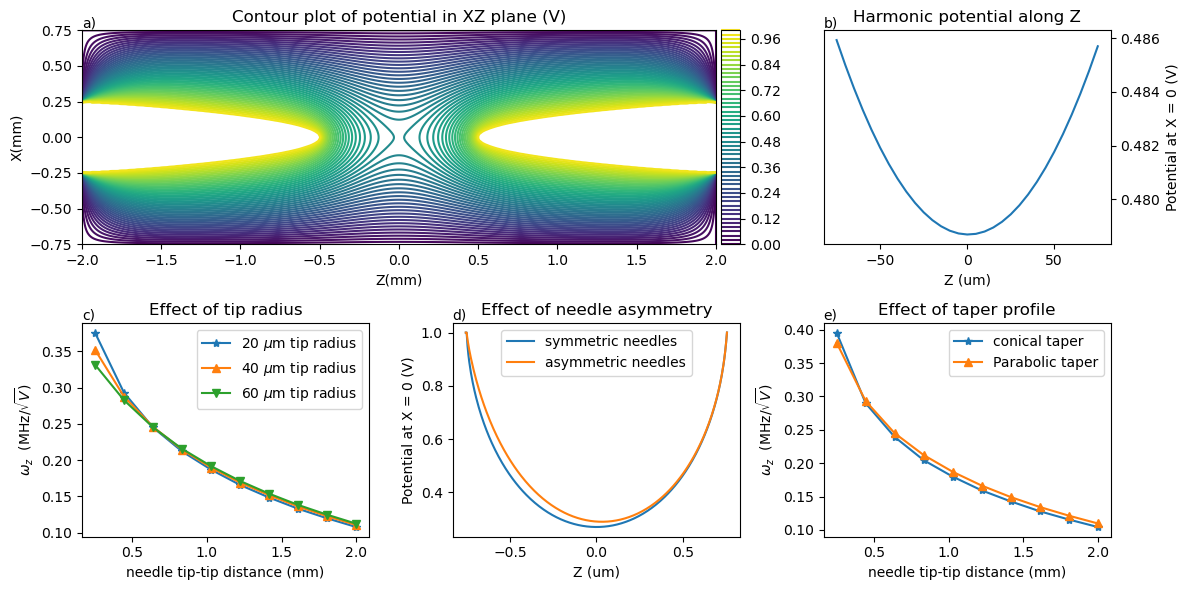

In [33]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(12,6))
gs = GridSpec(2, 3, figure=fig)
ax0 = fig.add_subplot(gs[0, :-1]) # needle potential contour plot
ax1 = fig.add_subplot(gs[0, 2]) # potential along z_axis
ax2 = fig.add_subplot(gs[1,0]) # radii of curvature
ax3 = fig.add_subplot(gs[1,1]) # asymmetric neeedles
ax4 = fig.add_subplot(gs[1,2]) # cones vs parabolas

# needle potential contour plot
parabolic_pair_solved = parabolic_pair_result['parabolic_pair_solved']
ax0.set_title('Contour plot of potential in XZ plane (V)')
im = ax0.contour(X,Y,parabolic_pair_solved,50)
ax0.set_xlabel('Z(mm)')
ax0.set_ylabel('X(mm)')
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="3%", pad=0.05)
plt.colorbar(im, cax=cax)
ax0.text(0, 1, 'a)',horizontalalignment='left',verticalalignment='bottom',transform=ax0.transAxes)

# potential along z_axis
x = parabolic_pair_result['z_data'] * 1e6
y = parabolic_pair_result['v_data']
ax1.plot(x,y)
ax1.set_xlabel('Z (um)')
ax1.set_ylabel('Potential at X = 0 (V)')
ax1.set_title('Harmonic potential along Z')
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
#ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.text(0, 1, 'b)',horizontalalignment='left',verticalalignment='bottom',transform=ax1.transAxes)

# radii of curvature
spacings = trap_freq_results['spacings']
trap_freq_20 = np.array(trap_freq_results['trap_freq_20']) * 1e-6
trap_freq_40 = np.array(trap_freq_results['trap_freq_40']) * 1e-6
trap_freq_60 = np.array(trap_freq_results['trap_freq_60']) * 1e-6

ax2.plot(spacings,trap_freq_20,label='20 $\mu$m tip radius',marker='*')
ax2.plot(spacings,trap_freq_40,label='40 $\mu$m tip radius',marker='^')
ax2.plot(spacings,trap_freq_60,label='60 $\mu$m tip radius',marker='v')
ax2.set_title('Effect of tip radius')
ax2.set_ylabel('$\omega_z$  (MHz/$\sqrt{V}$)')
ax2.set_xlabel('needle tip-tip distance (mm)')
ax2.legend()
ax2.text(0, 1, 'c)',horizontalalignment='left',verticalalignment='bottom',transform=ax2.transAxes)

#asymmetric needles
z = asym_needles_results['z_data']
v_sym = asym_needles_results['v_data_sym']
v_asym = asym_needles_results['v_data_asym']
ax3.plot(z,v_sym,label='symmetric needles')
ax3.plot(z,v_asym,label='asymmetric needles')
ax3.set_xlabel('Z (um)')
ax3.set_ylabel('Potential at X = 0 (V)')
ax3.set_title('Effect of needle asymmetry')
ax3.legend()
ax3.text(0, 1, 'd)',horizontalalignment='left',verticalalignment='bottom',transform=ax3.transAxes)

# cones vs parabolas
spacings = cone_vs_para_results['spacings']
cone_frequencies = np.array(cone_vs_para_results['cone_frequencies']) * 1e-6
parabolic_frequencies = np.array(cone_vs_para_results['parabolic_frequencies']) * 1e-6
ax4.plot(spacings,cone_frequencies,label='conical taper',marker='*')
ax4.plot(spacings,parabolic_frequencies,label='Parabolic taper',marker='^')
ax4.set_title('Effect of taper profile')
ax4.set_xlabel('needle tip-tip distance (mm)')
ax4.set_ylabel('$\omega_z$  (MHz/$\sqrt{V}$)')
ax4.legend()
ax4.text(0, 1, 'e)',horizontalalignment='left',verticalalignment='bottom',transform=ax4.transAxes)

fig.tight_layout()
plt.savefig('needle_shape_study.pdf')
plt.show()